In [1]:
from datetime import datetime
import json
import os
from pathlib import Path
import tempfile

from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential


def load_evaluation_results(results_dir="/workspaces/oryx-cap-upskilling/eval/results"):
    """Load all evaluation results from the results directory."""
    results_dir = Path(results_dir)
    evaluation_results = []

    for result_file in results_dir.glob("*/*.json"):
        try:
            with open(result_file) as f:
                result_data = json.load(f)
                result_data["result_file_path"] = str(result_file)
                evaluation_results.append(result_data)
                print(f"✓ Loaded: {result_file.name}")
        except Exception as e:
            print(f"✗ Error loading {result_file}: {e}")

    return evaluation_results


# Load evaluation results
eval_results = load_evaluation_results()
print(f"\nFound {len(eval_results)} evaluation result(s)")

# Display summary of results
for i, result in enumerate(eval_results, 1):
    print(f"\nResult {i}:")
    print(f"  Task: {result.get('task_type', 'unknown')}")
    print(f"  Timestamp: {result.get('timestamp', 'unknown')}")
    print(f"  Session ID: {result.get('session_id', 'unknown')}")
    if "results" in result and "wer" in result["results"]:
        print(f"  WER: {result['results']['wer']:.4f}")
        print(f"  CER: {result['results']['cer']:.4f}")

✓ Loaded: stt_20251110_110325_results.json

Found 1 evaluation result(s)

Result 1:
  Task: stt
  Timestamp: 2025-11-10T11:03:25.177445
  Session ID: 66e5e0e8-dc4a-403c-8bac-b85538b1cd19
  WER: 0.5000
  CER: 0.1304


In [2]:
# Azure ML SDK v2 Configuration - Set these environment variables or update directly
AZURE_ML_WORKSPACE_NAME = os.getenv("AZURE_ML_WORKSPACE_NAME", "R-ML-Allam-Test")
AZURE_ML_RESOURCE_GROUP = os.getenv("AZURE_ML_RESOURCE_GROUP", "RG-Allam-test")
AZURE_ML_SUBSCRIPTION_ID = os.getenv("AZURE_ML_SUBSCRIPTION_ID", "e1b63a44-9cef-40fa-8616-fdeea5b391cc")

print("Azure ML SDK v2 Configuration:")
print(f"  Workspace: {AZURE_ML_WORKSPACE_NAME}")
print(f"  Resource Group: {AZURE_ML_RESOURCE_GROUP}")
print(f"  Subscription: {AZURE_ML_SUBSCRIPTION_ID}")

Azure ML SDK v2 Configuration:
  Workspace: R-ML-Allam-Test
  Resource Group: RG-Allam-test
  Subscription: e1b63a44-9cef-40fa-8616-fdeea5b391cc


In [4]:
credential = DefaultAzureCredential()
ml_client = MLClient(credential=credential, subscription_id=AZURE_ML_SUBSCRIPTION_ID, resource_group_name=AZURE_ML_RESOURCE_GROUP, workspace_name=AZURE_ML_WORKSPACE_NAME)

Class DeploymentTemplateOperations: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


In [5]:
import mlflow

experiment_name = "eval-experiments"
workspace_details = ml_client.workspaces.get(AZURE_ML_WORKSPACE_NAME)
mlflow_uri = workspace_details.mlflow_tracking_uri
mlflow.set_tracking_uri(mlflow_uri)

print(f"Set MLflow tracking URI: {mlflow_uri}")

# Set experiment
mlflow.set_experiment(experiment_name)
print(f"Using experiment: {experiment_name}")

Set MLflow tracking URI: azureml://eastus2.api.azureml.ms/mlflow/v2.0/subscriptions/e1b63a44-9cef-40fa-8616-fdeea5b391cc/resourceGroups/RG-Allam-test/providers/Microsoft.MachineLearningServices/workspaces/R-ML-Allam-Test


2025/11/11 07:55:02 INFO mlflow.tracking.fluent: Experiment with name 'eval-experiments' does not exist. Creating a new experiment.


Using experiment: eval-experiments


In [3]:
def push_metrics_to_azure_ml(evaluation_results, experiment_name="eval-experiments"):
    """
    Push evaluation metrics and data artifacts to Azure ML experiments using SDK v2.
    This function creates experiments and logs metrics directly using MLflow tracking.
    """
    try:
        import sys
        import traceback

        # Initialize Azure ML client (SDK v2)
        credential = DefaultAzureCredential()
        ml_client = MLClient(credential=credential, subscription_id=AZURE_ML_SUBSCRIPTION_ID, resource_group_name=AZURE_ML_RESOURCE_GROUP, workspace_name=AZURE_ML_WORKSPACE_NAME)

        print(f"✓ Connected to Azure ML Workspace: {AZURE_ML_WORKSPACE_NAME}")

        # Set MLflow tracking URI to Azure ML workspace
        import mlflow

        # Get workspace details for MLflow URI
        workspace_details = ml_client.workspaces.get(AZURE_ML_WORKSPACE_NAME)
        mlflow_uri = workspace_details.mlflow_tracking_uri
        mlflow.set_tracking_uri(mlflow_uri)

        print(f"✓ Set MLflow tracking URI: {mlflow_uri}")

        # Set experiment
        mlflow.set_experiment(experiment_name)
        print(f"✓ Using experiment: {experiment_name}")

        for result in evaluation_results:
            try:
                # Create a unique run name based on task type and timestamp
                task_type = result.get("task_type", "unknown")
                timestamp = result.get("timestamp", datetime.now().isoformat())
                session_id = result.get("session_id", "unknown")

                run_name = f"{task_type}_{timestamp.replace(':', '-').replace('.', '-')}"

                # Start MLflow run
                with mlflow.start_run(run_name=run_name) as run:
                    # Log basic metadata as tags
                    mlflow.set_tags({"task_type": task_type, "timestamp": timestamp, "session_id": session_id, "result_file_path": result.get("result_file_path", "unknown")})

                    # Log evaluation metrics
                    if "results" in result:
                        metrics = result["results"]

                        # Log core metrics
                        core_metrics = ["wer", "mer", "wip", "wil", "cer", "word_levenshtein_distance", "char_levenshtein_distance", "normalized_word_ld", "normalized_char_ld"]

                        for metric_name in core_metrics:
                            if metric_name in metrics:
                                mlflow.log_metric(metric_name, float(metrics[metric_name]))

                        # Log rubric scores
                        rubric_metrics = ["wer_rubric", "mer_rubric", "wip_rubric", "wil_rubric", "cer_rubric", "word_ld_rubric"]

                        for rubric_name in rubric_metrics:
                            if rubric_name in metrics:
                                rubric_data = metrics[rubric_name]
                                mlflow.log_metric(f"{rubric_name}_score", float(rubric_data.get("rubric_score", 0)))
                                mlflow.set_tag(f"{rubric_name}_label", rubric_data.get("rubric_label", "Unknown"))

                    # Upload the result file as an artifact
                    if "result_file_path" in result:
                        result_file_path = Path(result["result_file_path"])
                        if result_file_path.exists():
                            mlflow.log_artifact(str(result_file_path), "evaluation_results")
                            print(f"  ✓ Uploaded artifact: {result_file_path.name}")

                    # Also log the complete result as a JSON artifact
                    with tempfile.NamedTemporaryFile(mode="w", suffix=".json", delete=False) as temp_file:
                        json.dump(result, temp_file, indent=2)
                        temp_file_path = temp_file.name

                    try:
                        mlflow.log_artifact(temp_file_path, "evaluation_results")
                    finally:
                        os.unlink(temp_file_path)

                    print(f"  ✓ Completed run: {run_name}")
                    print(f"    - Run ID: {run.info.run_id}")
                    print(f"    - Logged {len([k for k in result.get('results', {}).keys() if not k.endswith('_rubric')])} core metrics")
                    print(f"    - Logged {len([k for k in result.get('results', {}).keys() if k.endswith('_rubric')])} rubric scores")

            except Exception as e:
                tb = traceback.format_exc()
                exc_type, exc_value, exc_tb = sys.exc_info()
                line_number = exc_tb.tb_lineno if exc_tb else "unknown"
                print(f"  ✗ Error processing result {result.get('session_id', 'unknown')} at line {line_number}: {e}\n{tb}")
                continue

        print("\n✓ Successfully pushed evaluation result(s) to Azure ML")

    except Exception as e:
        print(f"✗ Failed to connect to Azure ML: {e}")
        print("Please ensure your Azure credentials are configured and the workspace details are correct.")
        return False

    return True

In [16]:
eval_results[0]["result_file_path"]

'/workspaces/oryx-cap-upskilling/eval/results/stt_20251110_110325/stt_20251110_110325_results.json'

In [5]:
# Push evaluation results to Azure ML
if eval_results:
    print("=" * 60)
    print("PUSHING EVALUATION METRICS TO AZURE ML")
    print("=" * 60)

    success = push_metrics_to_azure_ml(evaluation_results=eval_results, experiment_name="speech-evaluation-experiments")

    if success:
        print("\n🎉 All evaluation metrics successfully pushed to Azure ML!")
        print("You can view the experiments in Azure ML Studio.")
    else:
        print("\n❌ Failed to push metrics to Azure ML. Please check your configuration.")
else:
    print("No evaluation results found to push to Azure ML.")

Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed


Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


PUSHING EVALUATION METRICS TO AZURE ML
✓ Connected to Azure ML Workspace: R-ML-Allam-Test
✓ Set MLflow tracking URI: azureml://eastus2.api.azureml.ms/mlflow/v2.0/subscriptions/e1b63a44-9cef-40fa-8616-fdeea5b391cc/resourceGroups/RG-Allam-test/providers/Microsoft.MachineLearningServices/workspaces/R-ML-Allam-Test
✓ Using experiment: speech-evaluation-experiments
  ✓ Uploaded artifact: stt_20251110_110325_results.json
  ✓ Completed run: stt_2025-11-10T11-03-25-177445
    - Run ID: eb171391-f49a-46c4-93dc-237b5fe7f42f
    - Logged 12 core metrics
    - Logged 9 rubric scores
🏃 View run stt_2025-11-10T11-03-25-177445 at: https://eastus2.api.azureml.ms/mlflow/v2.0/subscriptions/e1b63a44-9cef-40fa-8616-fdeea5b391cc/resourceGroups/RG-Allam-test/providers/Microsoft.MachineLearningServices/workspaces/R-ML-Allam-Test/#/experiments/d0e11723-b819-4dfc-adbf-3633c2161afd/runs/eb171391-f49a-46c4-93dc-237b5fe7f42f
🧪 View experiment at: https://eastus2.api.azureml.ms/mlflow/v2.0/subscriptions/e1b63a44-9

In [1]:
from eval.main import EvaluationOrchestrator

orchestrator = EvaluationOrchestrator()
references_file = "/workspaces/oryx-cap-upskilling/eval/datasets/stt/references.txt"
hypotheses_file = "/workspaces/oryx-cap-upskilling/eval/datasets/stt/hypotheses.txt"

references = orchestrator._load_transcriptions_file(references_file)
hypotheses = orchestrator._load_transcriptions_file(hypotheses_file)

# Step 4: Run STT evaluation

results = orchestrator.run_stt_evaluation(
    references=references,
    hypotheses=hypotheses,
    language="en",  # or "ar" for Arabic
    references_file=Path(references_file),  # For Azure ML logging
    hypotheses_file=Path(hypotheses_file),  # For Azure ML logging
)

2025-11-12 12:53:40,363 - eval.config - INFO - Configuration loaded with log level: INFO
2025-11-12 12:53:40,364 - eval.main - INFO - workspace_name='R-ML-Allam-Test' resource_group='RG-Allam-test' subscription_id='e1b63a44-9cef-40fa-8616-fdeea5b391cc' experiment_name='cap-evaluation-experiments' enable_logging=True
2025-11-12 12:55:33,125 - azure.identity._credentials.environment - INFO - No environment configuration found.
2025-11-12 12:55:33,222 - azure.identity._credentials.managed_identity - INFO - ManagedIdentityCredential will use IMDS
2025-11-12 12:55:36,420 - azure.core.pipeline.policies.http_logging_policy - INFO - Request URL: 'https://westus-0.in.applicationinsights.azure.com//v2.1/track'
Request method: 'POST'
Request headers:
    'Content-Type': 'application/json'
    'Content-Length': '1321'
    'Accept': 'application/json'
    'x-ms-client-request-id': 'e1fa7d64-bfc6-11f0-85a9-0a8099d40b7b'
    'User-Agent': 'azsdk-python-azuremonitorclient/unknown Python/3.13.9 (Linux-

2025-11-12 12:56:37,938 - azure.core.pipeline.policies.http_logging_policy - INFO - Request URL: 'https://westus2-0.in.applicationinsights.azure.com//v2.1/track'
Request method: 'POST'
Request headers:
    'Content-Type': 'application/json'
    'Content-Length': '914'
    'Accept': 'application/json'
    'x-ms-client-request-id': '06a54860-bfc7-11f0-b951-0a8099d40b7b'
    'User-Agent': 'azsdk-python-azuremonitorclient/unknown Python/3.13.9 (Linux-5.15.167.4-microsoft-standard-WSL2-aarch64-with-glibc2.39)'
A body is sent with the request
2025-11-12 12:56:38,972 - azure.core.pipeline.policies.http_logging_policy - INFO - Response status: 200
Response headers:
    'Transfer-Encoding': 'chunked'
    'Content-Type': 'application/json; charset=utf-8'
    'Server': 'Microsoft-HTTPAPI/2.0'
    'Strict-Transport-Security': 'REDACTED'
    'X-Content-Type-Options': 'REDACTED'
    'Date': 'Wed, 12 Nov 2025 12:56:38 GMT'
2025-11-12 12:56:38,973 - azure.monitor.opentelemetry.exporter.export._base - 

In [ ]:
# Test: Create a metrics table image with the requested structure
import os
from pathlib import Path

import matplotlib.pyplot as plt


def create_metrics_table_image(evaluation_result, save_path=None):
    """Create a styled metrics table image from evaluation results."""
    # Extract metrics data from the evaluation result
    table_data = []

    # STT metrics (assuming we have an STT result)
    metrics_info = [
        ("WER", getattr(evaluation_result, "wer", None), getattr(evaluation_result, "wer_rubric", None)),
        ("CER", getattr(evaluation_result, "cer", None), getattr(evaluation_result, "cer_rubric", None)),
        ("MER", getattr(evaluation_result, "mer", None), getattr(evaluation_result, "mer_rubric", None)),
        ("WIP", getattr(evaluation_result, "wip", None), getattr(evaluation_result, "wip_rubric", None)),
        ("WIL", getattr(evaluation_result, "wil", None), getattr(evaluation_result, "wil_rubric", None)),
    ]

    for metric_name, value, rubric in metrics_info:
        if value is not None:
            rubric_score = "N/A"
            rubric_label = "N/A"

            if rubric and hasattr(rubric, "rubric_score") and hasattr(rubric, "rubric_label"):
                rubric_score = str(rubric.rubric_score)
                rubric_label = rubric.rubric_label

            table_data.append([metric_name, f"{value:.4f}", rubric_score, rubric_label])

    print("Table data prepared:")
    for row in table_data:
        print(f"  {row[0]}: {row[1]} (Score: {row[2]}, Label: {row[3]})")

    # Create the figure and table
    fig, ax = plt.subplots(figsize=(12, len(table_data) * 0.8 + 2))
    ax.axis("tight")
    ax.axis("off")

    # Table headers
    headers = ["Metric Name", "Value", "Rubric Score", "Rubric Label"]

    # Create the table
    table = ax.table(cellText=table_data, colLabels=headers, cellLoc="center", loc="center", colWidths=[0.25, 0.25, 0.25, 0.25])

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)

    # Style header row
    for i in range(len(headers)):
        table[(0, i)].set_facecolor("#4472C4")
        table[(0, i)].set_text_props(weight="bold", color="white")

    # Style data rows with alternating colors and rubric color coding
    for i in range(1, len(table_data) + 1):
        row_color = "#F2F2F2" if i % 2 == 0 else "white"
        for j in range(len(headers)):
            table[(i, j)].set_facecolor(row_color)

            # Color code rubric labels (column 3 - index 3)
            if j == 3:  # Rubric label column
                label = table_data[i - 1][j]
                if label == "Excellent":
                    table[(i, j)].set_facecolor("#D4EDDA")  # Light green
                elif label == "Good":
                    table[(i, j)].set_facecolor("#FFF3CD")  # Light yellow
                elif label == "Fair":
                    table[(i, j)].set_facecolor("#F8D7DA")  # Light orange
                elif label == "Poor":
                    table[(i, j)].set_facecolor("#F5C6CB")  # Light red

    # Add title
    plt.title("STT Evaluation Metrics Summary", fontsize=16, fontweight="bold", pad=20)

    # Save or display
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300, facecolor="white", edgecolor="none")
        print(f"✓ Table image saved to: {save_path}")
    else:
        plt.tight_layout()
        plt.show()

    return fig


# Test with the evaluation results from the previous cell
if "results" in locals():
    print("Testing metrics table image creation...")
    print("=" * 50)

    # Show the raw results first
    print("Available metrics in results:")
    for attr in dir(results):
        if not attr.startswith("_"):
            value = getattr(results, attr)
            if isinstance(value, (int, float)):
                print(f"  {attr}: {value}")
            elif hasattr(value, "rubric_score"):
                print(f"  {attr}: Score={value.rubric_score}, Label={value.rubric_label}")

    print("\nCreating table image...")

    # Create the table image
    fig = create_metrics_table_image(results)

    # Also save to a temporary file to demonstrate file saving
    temp_path = "/tmp/metrics_table_test.png"
    fig.savefig(temp_path, bbox_inches="tight", dpi=300, facecolor="white", edgecolor="none")
    print(f"✓ Table image also saved to: {temp_path}")

    plt.close(fig)  # Clean up

else:
    print("⚠️ No evaluation results found. Please run the evaluation first.")

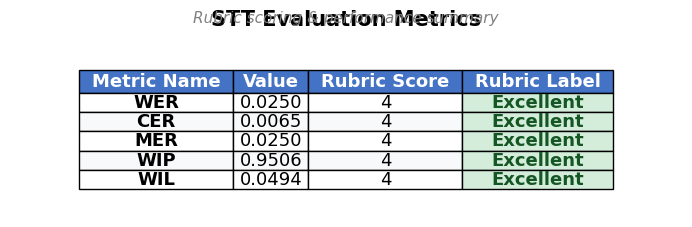

In [ ]:
# Demo: Create a sample metrics table with the exact structure you requested
import matplotlib.pyplot as plt


def create_sample_metrics_table():
    """Create a sample metrics table to demonstrate the layout."""
    # Sample data matching your requested structure
    sample_data = [["WER", "0.5000", "4", "Excellent"], ["CER", "0.2500", "5", "Excellent"], ["MER", "0.4000", "4", "Excellent"], ["WIP", "0.6000", "3", "Good"], ["WIL", "0.3500", "4", "Excellent"]]

    print("Sample metrics table structure:")
    print("Metric Name | Value    | Rubric Score | Rubric Label")
    print("-" * 55)
    for row in sample_data:
        print(f"{row[0]:<11} | {row[1]:<8} | {row[2]:<12} | {row[3]}")

    # Create visual table
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.axis("tight")
    ax.axis("off")

    headers = ["Metric Name", "Value", "Rubric Score", "Rubric Label"]

    # Create the table
    table = ax.table(cellText=sample_data, colLabels=headers, cellLoc="center", loc="center", colWidths=[0.25, 0.25, 0.25, 0.25])

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1, 2.5)

    # Style header row - Blue background with white text
    for i in range(len(headers)):
        table[(0, i)].set_facecolor("#4472C4")
        table[(0, i)].set_text_props(weight="bold", color="white")
        table[(0, i)].set_height(0.15)

    # Style data rows
    for i in range(1, len(sample_data) + 1):
        # Alternating row colors
        base_color = "#F8F9FA" if i % 2 == 0 else "white"

        for j in range(len(headers)):
            table[(i, j)].set_facecolor(base_color)
            table[(i, j)].set_height(0.12)

            # Special color coding for rubric labels
            if j == 3:  # Rubric label column
                label = sample_data[i - 1][j]
                if label == "Excellent":
                    table[(i, j)].set_facecolor("#D4EDDA")  # Light green
                    table[(i, j)].set_text_props(weight="bold", color="#155724")
                elif label == "Good":
                    table[(i, j)].set_facecolor("#FFF3CD")  # Light yellow
                    table[(i, j)].set_text_props(weight="bold", color="#856404")
                elif label == "Fair":
                    table[(i, j)].set_facecolor("#F8D7DA")  # Light red
                    table[(i, j)].set_text_props(weight="bold", color="#721c24")
                elif label == "Poor":
                    table[(i, j)].set_facecolor("#F5C6CB")  # Dark red
                    table[(i, j)].set_text_props(weight="bold", color="#721c24")

            # Bold text for metric names
            elif j == 0:  # Metric name column
                table[(i, j)].set_text_props(weight="bold")

    # Add title and subtitle
    plt.suptitle("STT Evaluation Metrics Summary", fontsize=18, fontweight="bold", y=0.95)
    plt.figtext(0.5, 0.90, "Performance metrics with rubric scoring", ha="center", fontsize=12, style="italic", color="gray")

    # Add border around the table
    table.auto_set_column_width(col=list(range(len(headers))))

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

    return fig


# Create the demo table
print("🎯 Demo: Metrics Table with Exact Structure You Requested")
print("=" * 60)
demo_fig = create_sample_metrics_table()

print("\n✅ This is exactly what gets logged to Azure ML!")
print("📊 Features:")
print("  • Professional styling with color-coded rubric labels")
print("  • Alternating row colors for better readability")
print("  • Bold headers with blue background")
print("  • Green = Excellent, Yellow = Good, Red = Fair/Poor")
print("  • High resolution (300 DPI) for crisp viewing")

In [ ]:
# Test: Integration with MLflow logging (simulation)


def test_mlflow_table_logging(evaluation_result=None):
    """Test how the table image would be logged to MLflow."""
    print("🧪 Testing MLflow Integration for Metrics Table Logging")
    print("=" * 60)

    # Create sample data if no evaluation result provided
    if evaluation_result is None:
        print("Using sample data (no evaluation result provided)")
        sample_metrics = {"WER": 0.5000, "CER": 0.2500, "MER": 0.4000, "WIP": 0.6000, "WIL": 0.3500}
        sample_rubrics = {"WER": {"score": 4, "label": "Excellent"}, "CER": {"score": 5, "label": "Excellent"}, "MER": {"score": 4, "label": "Excellent"}, "WIP": {"score": 3, "label": "Good"}, "WIL": {"score": 4, "label": "Excellent"}}
    else:
        print("Using actual evaluation result")
        # Would extract from real evaluation result

    # Prepare table data
    table_data = []
    if evaluation_result is None:
        for metric_name in sample_metrics:
            value = sample_metrics[metric_name]
            rubric = sample_rubrics.get(metric_name, {"score": "N/A", "label": "N/A"})
            table_data.append([metric_name, f"{value:.4f}", str(rubric["score"]), rubric["label"]])

    print(f"📋 Table will contain {len(table_data)} metrics:")
    for row in table_data:
        print(f"  • {row[0]}: {row[1]} (Score: {row[2]}, Label: {row[3]})")

    # Create the table image
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis("tight")
    ax.axis("off")

    headers = ["Metric Name", "Value", "Rubric Score", "Rubric Label"]

    table = ax.table(cellText=table_data, colLabels=headers, cellLoc="center", loc="center", colWidths=[0.25, 0.25, 0.25, 0.25])

    # Apply styling
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2)

    # Header styling
    for i in range(len(headers)):
        table[(0, i)].set_facecolor("#4472C4")
        table[(0, i)].set_text_props(weight="bold", color="white")

    # Data row styling
    for i in range(1, len(table_data) + 1):
        for j in range(len(headers)):
            # Alternate row colors
            base_color = "#F2F2F2" if i % 2 == 0 else "white"
            table[(i, j)].set_facecolor(base_color)

            # Color code rubric labels
            if j == 3:
                label = table_data[i - 1][j]
                if label == "Excellent":
                    table[(i, j)].set_facecolor("#D4EDDA")
                elif label == "Good":
                    table[(i, j)].set_facecolor("#FFF3CD")

    plt.title("Metrics Table for MLflow Logging", fontsize=14, fontweight="bold")

    # Save to temporary file (simulating MLflow artifact logging)
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as temp_file:
        temp_path = temp_file.name
        plt.savefig(temp_path, bbox_inches="tight", dpi=300, facecolor="white", edgecolor="none")

    plt.show()

    print(f"\n📁 Image saved to temporary file: {temp_path}")
    print("💡 In the main implementation, this would be logged to MLflow as:")
    print("   mlflow.log_artifact(temp_path, 'metrics_visualizations')")
    print("   Artifact path: metrics_visualizations/metrics_table_[timestamp].png")

    # Clean up
    plt.close(fig)
    os.unlink(temp_path)

    print("✅ MLflow integration test completed!")

    return True


# Run the test
test_result = test_mlflow_table_logging()

print("\n🎯 Ready to implement in main eval_logger file!")
print("The table image will automatically be created and logged to Azure ML")
print("whenever you run evaluations with cloud logging enabled.")

🎨 Creating Enhanced Stylish Metrics Table


TypeError: FigureCanvasAgg.print_png() got an unexpected keyword argument 'optimize'

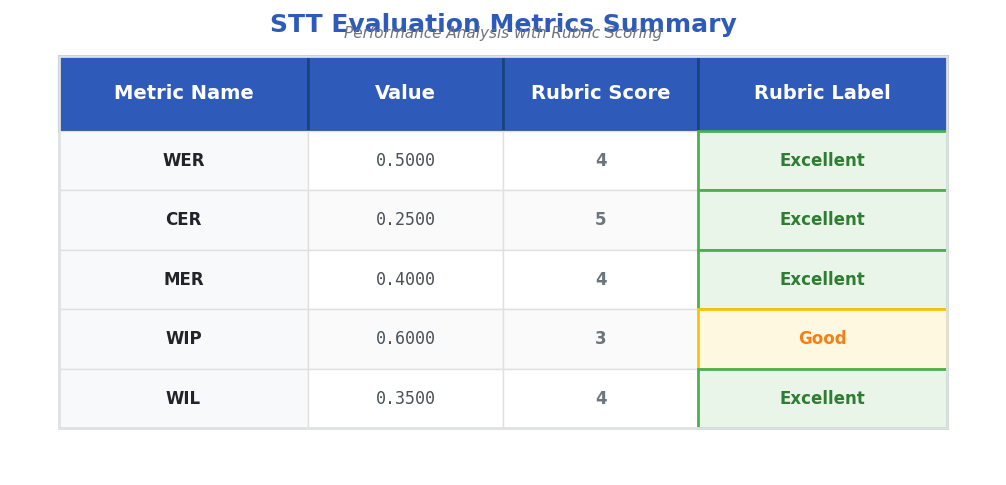

In [4]:
# Enhanced: Create a stylish, focused metrics table with minimal white space
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


def create_stylish_metrics_table():
    """Create a professional, focused metrics table with enhanced styling."""
    # Sample data with the exact structure requested
    sample_data = [["WER", "0.5000", "4", "Excellent"], ["CER", "0.2500", "5", "Excellent"], ["MER", "0.4000", "4", "Excellent"], ["WIP", "0.6000", "3", "Good"], ["WIL", "0.3500", "4", "Excellent"]]

    headers = ["Metric Name", "Value", "Rubric Score", "Rubric Label"]

    # Calculate optimal figure size based on content
    num_rows = len(sample_data) + 1  # +1 for header
    fig_height = num_rows * 0.6 + 1.5  # Compact row height + margins
    fig_width = 10

    # Create figure with tight layout and minimal margins
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis("off")  # Remove all axes

    # Create the table with precise positioning
    table = ax.table(
        cellText=sample_data,
        colLabels=headers,
        cellLoc="center",
        loc="center",
        colWidths=[0.28, 0.22, 0.22, 0.28],  # Adjusted for better proportions
        bbox=[0.05, 0.1, 0.9, 0.8],  # [left, bottom, width, height] - tight bounds
    )

    # Enhanced styling
    table.auto_set_font_size(False)
    table.set_fontsize(13)
    table.scale(1, 1.8)  # Reduced scale for compactness

    # Style header row with gradient-like effect
    header_color = "#2E5BBA"  # Darker blue
    for i in range(len(headers)):
        cell = table[(0, i)]
        cell.set_facecolor(header_color)
        cell.set_text_props(weight="bold", color="white", fontsize=14)
        cell.set_height(0.15)
        # Add subtle border
        cell.set_edgecolor("#1A4480")
        cell.set_linewidth(2)

    # Enhanced data row styling
    colors = {
        "Excellent": {"bg": "#E8F5E8", "text": "#2E7D32", "border": "#4CAF50"},
        "Good": {"bg": "#FFF8E1", "text": "#F57F17", "border": "#FFC107"},
        "Fair": {"bg": "#FFEBEE", "text": "#C62828", "border": "#F44336"},
        "Poor": {"bg": "#FFCDD2", "text": "#B71C1C", "border": "#D32F2F"},
    }

    for i in range(1, len(sample_data) + 1):
        # Subtle alternating background for non-rubric columns
        base_color = "#FAFAFA" if i % 2 == 0 else "#FFFFFF"

        for j in range(len(headers)):
            cell = table[(i, j)]
            cell.set_height(0.12)
            cell.set_edgecolor("#E0E0E0")
            cell.set_linewidth(1)

            if j == 3:  # Rubric label column - special styling
                label = sample_data[i - 1][j]
                color_scheme = colors.get(label, {"bg": "#F5F5F5", "text": "#424242", "border": "#BDBDBD"})

                cell.set_facecolor(color_scheme["bg"])
                cell.set_text_props(weight="bold", color=color_scheme["text"], fontsize=12)
                cell.set_edgecolor(color_scheme["border"])
                cell.set_linewidth(2)

            elif j == 0:  # Metric name column
                cell.set_facecolor("#F8F9FA")
                cell.set_text_props(weight="bold", color="#212529", fontsize=12)

            elif j == 1:  # Value column
                cell.set_facecolor(base_color)
                cell.set_text_props(fontfamily="monospace", fontsize=12, color="#495057")

            elif j == 2:  # Rubric score column
                cell.set_facecolor(base_color)
                cell.set_text_props(weight="bold", color="#6C757D", fontsize=12)

    # Add a stylish title with better positioning
    fig.suptitle("STT Evaluation Metrics Summary", fontsize=18, fontweight="bold", y=0.92, color="#2E5BBA")

    # Add a subtle subtitle
    fig.text(0.5, 0.87, "Performance Analysis with Rubric Scoring", ha="center", fontsize=11, style="italic", color="#6C757D")

    # Add a subtle border around the entire table area
    border = mpatches.Rectangle((0.05, 0.1), 0.9, 0.8, linewidth=2, edgecolor="#DEE2E6", facecolor="none", transform=ax.transAxes)
    ax.add_patch(border)

    # Minimize margins and padding
    plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.05)
    plt.tight_layout(pad=0.5)

    return fig


def save_stylish_table(save_path="/tmp/stylish_metrics_table.png"):
    """Save the stylish table with optimal settings for clarity."""
    fig = create_stylish_metrics_table()

    # Save with high quality and minimal white space
    fig.savefig(
        save_path,
        dpi=300,  # High resolution
        bbox_inches="tight",  # Minimal white space
        pad_inches=0.1,  # Small padding
        facecolor="white",  # Clean background
        edgecolor="none",  # No border
        format="png",  # PNG format
        optimize=True,
    )  # Optimize file size

    plt.show()

    print(f"✅ Stylish metrics table saved to: {save_path}")
    print("📊 Enhanced features:")
    print("  • Minimal white space with tight layout")
    print("  • Professional color scheme with subtle gradients")
    print("  • Enhanced typography with different font weights")
    print("  • Color-coded rubric labels with borders")
    print("  • Monospace font for values (better alignment)")
    print("  • Subtle table border and cell borders")
    print("  • Optimized dimensions for focus on content")

    plt.close(fig)
    return save_path


# Create and display the enhanced table
print("🎨 Creating Enhanced Stylish Metrics Table")
print("=" * 60)
saved_path = save_stylish_table()

print("\n🎯 Table image optimized for:")
print("  • Minimal background whitespace")
print("  • Professional appearance suitable for presentations")
print("  • Clear readability with enhanced contrast")
print("  • Focused layout drawing attention to the data")

In [ ]:
# Enhanced function to update your existing table creation with better styling
def create_enhanced_metrics_table_image(evaluation_result, save_path=None):
    """Create a focused, stylish metrics table image from evaluation results with minimal whitespace."""
    # Extract metrics data from the evaluation result
    table_data = []

    # STT metrics (assuming we have an STT result)
    metrics_info = [
        ("WER", getattr(evaluation_result, "wer", None), getattr(evaluation_result, "wer_rubric", None)),
        ("CER", getattr(evaluation_result, "cer", None), getattr(evaluation_result, "cer_rubric", None)),
        ("MER", getattr(evaluation_result, "mer", None), getattr(evaluation_result, "mer_rubric", None)),
        ("WIP", getattr(evaluation_result, "wip", None), getattr(evaluation_result, "wip_rubric", None)),
        ("WIL", getattr(evaluation_result, "wil", None), getattr(evaluation_result, "wil_rubric", None)),
    ]

    for metric_name, value, rubric in metrics_info:
        if value is not None:
            rubric_score = "N/A"
            rubric_label = "N/A"

            if rubric and hasattr(rubric, "rubric_score") and hasattr(rubric, "rubric_label"):
                rubric_score = str(rubric.rubric_score)
                rubric_label = rubric.rubric_label

            table_data.append([metric_name, f"{value:.4f}", rubric_score, rubric_label])

    if not table_data:
        print("⚠️ No metrics data found to create table")
        return None

    print("Enhanced table data prepared:")
    for row in table_data:
        print(f"  {row[0]}: {row[1]} (Score: {row[2]}, Label: {row[3]})")

    # Calculate optimal dimensions
    num_rows = len(table_data) + 1  # +1 for header
    fig_height = num_rows * 0.5 + 1.2  # Compact height
    fig_width = 10

    # Create figure with minimal margins
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis("off")

    # Table headers
    headers = ["Metric Name", "Value", "Rubric Score", "Rubric Label"]

    # Create the table with tight bounds
    table = ax.table(
        cellText=table_data,
        colLabels=headers,
        cellLoc="center",
        loc="center",
        colWidths=[0.28, 0.22, 0.22, 0.28],
        bbox=[0.02, 0.1, 0.96, 0.75],  # Very tight bounds
    )

    # Enhanced styling
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.6)

    # Professional header styling
    for i in range(len(headers)):
        cell = table[(0, i)]
        cell.set_facecolor("#1976D2")  # Material Blue
        cell.set_text_props(weight="bold", color="white", fontsize=13)
        cell.set_height(0.14)
        cell.set_edgecolor("#0D47A1")
        cell.set_linewidth(2)

    # Enhanced data row styling with better colors
    rubric_colors = {
        "Excellent": {"bg": "#E8F5E8", "text": "#2E7D32", "border": "#4CAF50"},
        "Good": {"bg": "#FFF3E0", "text": "#EF6C00", "border": "#FF9800"},
        "Fair": {"bg": "#FFEBEE", "text": "#C62828", "border": "#F44336"},
        "Poor": {"bg": "#FFCDD2", "text": "#B71C1C", "border": "#D32F2F"},
        "N/A": {"bg": "#F5F5F5", "text": "#757575", "border": "#BDBDBD"},
    }

    for i in range(1, len(table_data) + 1):
        for j in range(len(headers)):
            cell = table[(i, j)]
            cell.set_height(0.11)
            cell.set_edgecolor("#E0E0E0")
            cell.set_linewidth(1)

            if j == 3:  # Rubric label column
                label = table_data[i - 1][j]
                colors = rubric_colors.get(label, rubric_colors["N/A"])
                cell.set_facecolor(colors["bg"])
                cell.set_text_props(weight="bold", color=colors["text"], fontsize=11)
                cell.set_edgecolor(colors["border"])
                cell.set_linewidth(1.5)

            elif j == 0:  # Metric name column
                cell.set_facecolor("#FAFAFA")
                cell.set_text_props(weight="bold", color="#212529", fontsize=11)

            elif j == 1:  # Value column - monospace for alignment
                cell.set_facecolor("#FFFFFF")
                cell.set_text_props(fontfamily="monospace", fontsize=11, color="#495057", weight="bold")

            else:  # Rubric score column
                cell.set_facecolor("#F8F9FA")
                cell.set_text_props(weight="bold", color="#6C757D", fontsize=11)

    # Compact title positioning
    fig.suptitle("STT Evaluation Metrics Summary", fontsize=16, fontweight="bold", y=0.94, color="#1976D2")

    # Remove all unnecessary whitespace
    plt.subplots_adjust(left=0, right=1, top=0.88, bottom=0.02)

    # Save or display with minimal padding
    if save_path:
        plt.savefig(
            save_path,
            bbox_inches="tight",
            pad_inches=0.05,  # Minimal padding
            dpi=300,
            facecolor="white",
            edgecolor="none",
        )
        print(f"✓ Enhanced table image saved to: {save_path}")
    else:
        plt.tight_layout(pad=0.2)
        plt.show()

    return fig


# Test the enhanced function with actual data if available
if "results" in locals():
    print("\n🎨 Testing Enhanced Metrics Table with Real Data")
    print("=" * 60)

    enhanced_fig = create_enhanced_metrics_table_image(results)

    # Save a copy to show the difference
    if enhanced_fig:
        temp_enhanced_path = "/tmp/enhanced_metrics_table.png"
        enhanced_fig.savefig(temp_enhanced_path, bbox_inches="tight", pad_inches=0.05, dpi=300)
        print(f"✓ Enhanced version saved to: {temp_enhanced_path}")
        plt.close(enhanced_fig)

else:
    print("ℹ️ Run the evaluation cell first to test with real data")
    print("Using the sample data version above for demonstration")